<a href="https://colab.research.google.com/github/XavierCachan/moduleIA_S4/blob/main/Test_Neurone_artificiel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Retour vers la partie 2 : Caractérisation d'une batterie par optimisation](https://colab.research.google.com/drive/1JXGgboVAfwCTm1tow6axvQS3vtgH3vH3#scrollTo=4B-_OgfjO2Ab)

# **TP IA Partie 5 beta - Classification par réseau de neurones artificiels - IUT de Cachan GEII2 2024**
XM - Février 2024 - Version : 0.3

-----

Note : Pour avancer dans ce notebook, il suffit d'exécuter (petite flèche), ou compléter puis exécuter, les différents blocs de code placés ci-dessous.

Pour cette troisième partie, nous allons traiter le même problème de carctérisation de batterie que dans la partie 2, mais cette fois en utilisant les modules Python permettant de créer des neurones artificiels. Le modèle recherché est donc toujours **U_bat = E - Ri * I_bat**  

**1. Import des modules nécessaires pour les calculs et l'affichage**

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd         # Module pour la construction d'un réseau de neurones

#import pandas as pd               # Module pour la construction d'un réseau de neurones
#import tensorflow as tf           # TensorFlow est LE module utilisé pour l'entrainement d'un réseau de neurones
#import numpy as np                # Module de fonctions mathématiques
#import matplotlib.pyplot as plt   # Module pour l'affichage

**2. Fabrication des signaux de mesure de tension U_mes (ce sont les mêmes codes que dans la Partie 2)**

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 2s 0us/step


Pour rendre le cas plus réel, on ajoute du bruit de mesure

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


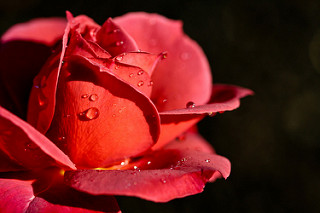

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))


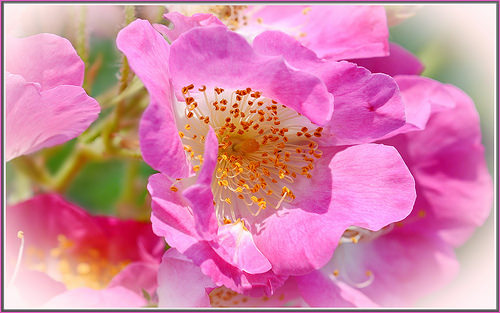

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

**3. Recherche des paramètres de la batterie avec un neurone**

Un neurone artificiel (voir dessin ci-dessous) associe des poids w à chacune de ses entrées x (=caractéristiques), et ajoute un biais b. On peut ensuite ajouter une fonction d'activation f pour obtenir la sortie y (=étiquette). Si l'on prend une seule entrée, et pas de fonction d'activation, on retrouve le y = w * x + b de la partie 2 !

In [ ]:
batch_size = 32
img_height = 180
img_width = 180


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)


['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


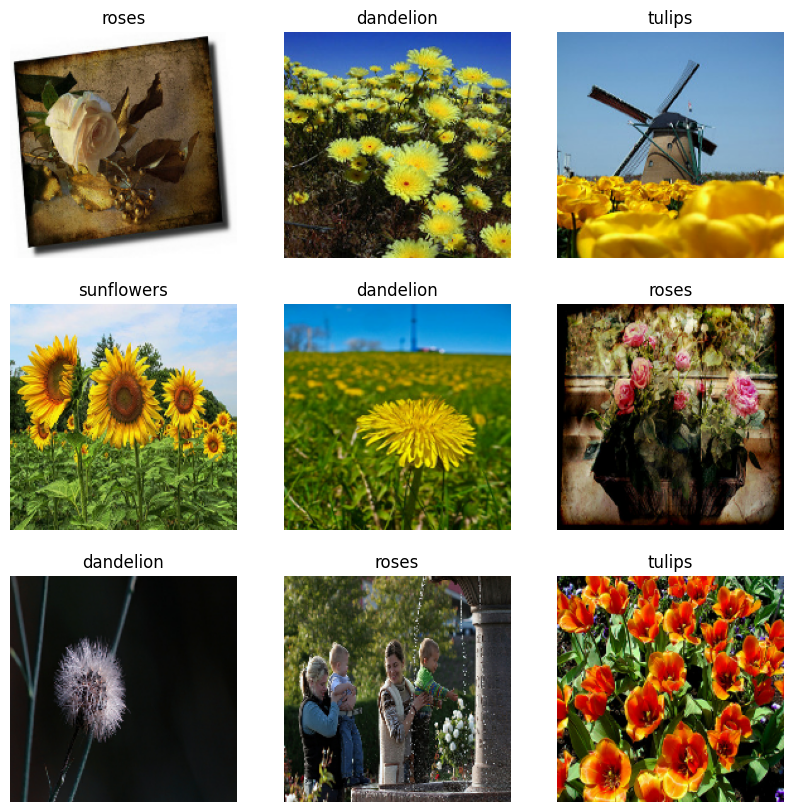

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)


In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)


Epoch 1/15
92/92 [==============================] - 5s 28ms/step - loss: 1.2997 - accuracy: 0.4360 - val_loss: 1.1503 - val_accuracy: 0.5450
Epoch 2/15
92/92 [==============================] - 2s 25ms/step - loss: 0.9874 - accuracy: 0.6073 - val_loss: 0.9892 - val_accuracy: 0.5886
Epoch 3/15
92/92 [==============================] - 2s 25ms/step - loss: 0.7966 - accuracy: 0.6832 - val_loss: 1.0504 - val_accuracy: 0.5749
Epoch 4/15
92/92 [==============================] - 2s 25ms/step - loss: 0.6489 - accuracy: 0.7350 - val_loss: 1.1483 - val_accuracy: 0.5790
Epoch 5/15
92/92 [==============================] - 3s 28ms/step - loss: 0.4878 - accuracy: 0.8225 - val_loss: 1.2788 - val_accuracy: 0.5940
Epoch 6/15
92/92 [==============================] - 2s 25ms/step - loss: 0.4231 - accuracy: 0.8406 - val_loss: 1.2628 - val_accuracy: 0.6458
Epoch 7/15
92/92 [==============================] - 2s 25ms/step - loss: 0.3574 - accuracy: 0.8723 - val_loss: 1.6005 - val_accuracy: 0.6022
Epoch 8/15
92

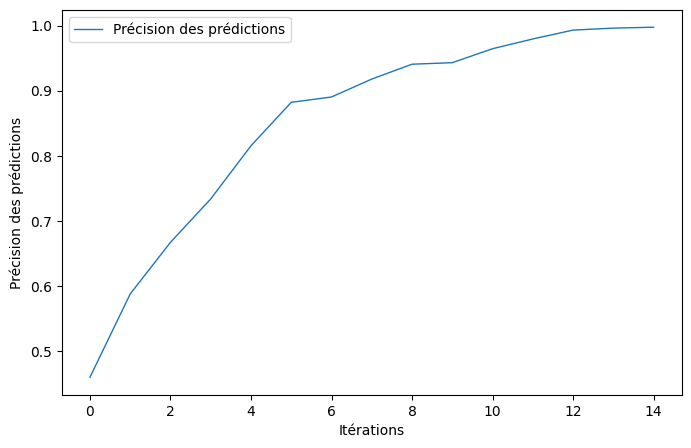

In [ ]:
  # Récupération de la liste des itérations
epochs = history.epoch

hist = pd.DataFrame(history.history)


# Affichage de l'évolution du taux de prédiction
fig,ax = plt.subplots(1,figsize=(8,5))
ax.plot (epochs,hist['accuracy'], linestyle="-", linewidth=1, label="Précision des prédictions")
ax.set_xlabel("Itérations")
ax.set_ylabel("Précision des prédictions")
ax.legend()
plt.show()

In [ ]:
loss, acc = model.evaluate(val_ds, batch_size=batch_size)

print("Précision obtenue : {:5.2f}%".format(100 * acc))


23/23 [==============================] - 7s 319ms/step - loss: 2.8562 - accuracy: 0.6417
Précision obtenue : 64.17%


In [ ]:
loss2, acc2 = model.evaluate(train_ds, batch_size=batch_size)

print("Précision obtenue sur entraienement : {:5.2f}%".format(100 * acc2))

92/92 [==============================] - 28s 304ms/step - loss: 3.6006e-04 - accuracy: 1.0000
Précision obtenue sur entraienement : 100.00%


In [ ]:
# Choisissons un exemple particulier de la base de test
exemple = 0    # Choix d'une caractéristique de la base de test (rappel : taille = 10000)  # Par défaut = 5
# Prédiction sur un exemple particulier de la base de test
model.predict(val_ds, verbose=0)[exemple]

array([  0.5326062,  11.229001 ,  -1.8347884, -14.853343 ,   1.9934294],
      dtype=float32)

In [ ]:
# Recherche de l'indice de probabilité maximale
#np.argmax(model.predict(val, verbose=0)[exemple])   # Recherche de l'indice associé
print ("Notre modèle IA dit que la fleur sur l'image est : " + str(class_names[np.argmax(model.predict(val_ds, verbose=0)[exemple])]))

Notre modèle IA dit que la fleur sur l'image est : dandelion


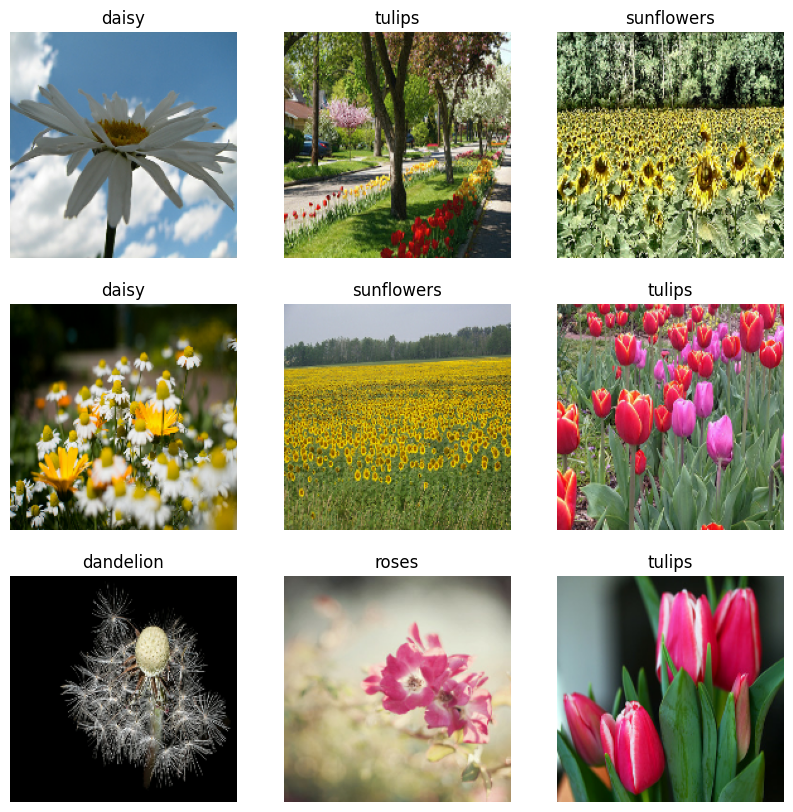

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Choisissons un exemple particulier de la base de test
exemple = 6    # Choix d'une caractéristique de la base de test (rappel : taille = 10000)  # Par défaut = 5
#model.predict(train_ds, verbose=0)[exemple]
print ("Notre modèle IA dit que la fleur sur l'image est : " + str(class_names[np.argmax(model.predict(train_ds, verbose=0)[exemple])]))

Notre modèle IA dit que la fleur sur l'image est : sunflowers


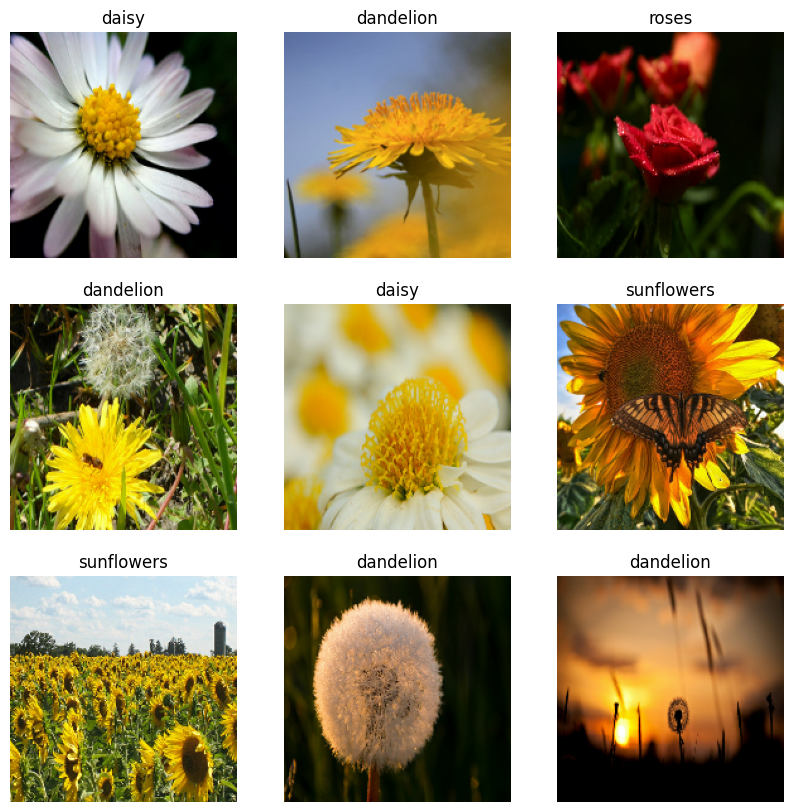

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Pour travailler avec un réseau de neurones, il faut commencer par écrire **une fonction pour définir le réseau** : nombre de couches, type de couche, nombre de neurones par couches, ... Ici pour cette première approche un seul neurone est suffisant pour retrouver une équation y = w * x + b pour laquelle on espère obtenir après entrainement w = -Ri_th et b = E_th.